In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader


In [16]:
# Configuration parameters
IMAGE_SIZE = 64  # Resize all images to 64x64
BATCH_SIZE = 128  # Batch size
LATENT_DIM = 100  # Size of the noise vector
EPOCHS = 1 # Number of training epochs
LEARNING_RATE = 0.0002
BETA1 = 0.5  # Beta1 for Adam optimizer
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [17]:
# Dataset Preprocessing
def get_dataloader(dataset_path):
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader

In [18]:
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)


In [19]:
# Training Function
def train_dcgan(dataset_path):
    dataloader = get_dataloader(dataset_path)
    generator = Generator().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
    fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=DEVICE)
    
    for epoch in range(EPOCHS):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(DEVICE)
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, 1, device=DEVICE)
            fake_labels = torch.zeros(batch_size, 1, device=DEVICE)

            # Train Discriminator
            optimizer_d.zero_grad()
            real_output = discriminator(real_images).view(-1, 1)
            loss_real = criterion(real_output, real_labels)
            noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images.detach()).view(-1, 1)
            loss_fake = criterion(fake_output, fake_labels)
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = discriminator(fake_images).view(-1, 1)
            loss_g = criterion(fake_output, real_labels)
            loss_g.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{EPOCHS}] Batch {i}/{len(dataloader)}: Loss D: {loss_d.item()}, Loss G: {loss_g.item()}")
                vutils.save_image(fake_images, f"results/fake_samples_epoch_{epoch}.png", normalize=True)

        torch.save(generator.state_dict(), f"models/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"models/discriminator_epoch_{epoch}.pth")


In [20]:
# Generate Images
def generate_images(model_path, num_images=16):
    generator = Generator().to(DEVICE)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    noise = torch.randn(num_images, LATENT_DIM, 1, 1, device=DEVICE)
    with torch.no_grad():
        fake_images = generator(noise)
    vutils.save_image(fake_images, "results/generated_samples.png", normalize=True)
    print("Generated images saved at results/generated_samples.png")

In [21]:
# Example Usage
if __name__ == "__main__":
    dataset_path = "C:\\Users\\rushi\\Desktop\\GAN\\data\\archive\\img_align_celeba"  # Updated to local CelebA dataset path
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    train_dcgan(dataset_path)
    generate_images("models/generator_epoch_49.pth")

Epoch [0/1] Batch 0/1583: Loss D: 1.4604164361953735, Loss G: 2.353747606277466
Epoch [0/1] Batch 100/1583: Loss D: 2.3215692043304443, Loss G: 6.869035720825195
Epoch [0/1] Batch 200/1583: Loss D: 0.4723072648048401, Loss G: 3.584974527359009
Epoch [0/1] Batch 300/1583: Loss D: 1.452738881111145, Loss G: 7.517622947692871
Epoch [0/1] Batch 400/1583: Loss D: 0.7451299428939819, Loss G: 2.905808448791504
Epoch [0/1] Batch 500/1583: Loss D: 0.47209519147872925, Loss G: 3.1317648887634277
Epoch [0/1] Batch 600/1583: Loss D: 0.6555466651916504, Loss G: 2.02713942527771
Epoch [0/1] Batch 700/1583: Loss D: 1.0204728841781616, Loss G: 5.575657844543457
Epoch [0/1] Batch 800/1583: Loss D: 0.772428035736084, Loss G: 4.268492698669434
Epoch [0/1] Batch 900/1583: Loss D: 0.8202477693557739, Loss G: 5.779880046844482
Epoch [0/1] Batch 1000/1583: Loss D: 0.45304349064826965, Loss G: 2.6016623973846436
Epoch [0/1] Batch 1100/1583: Loss D: 1.1053727865219116, Loss G: 6.774762153625488
Epoch [0/1] Bat

FileNotFoundError: [Errno 2] No such file or directory: 'models/generator_epoch_49.pth'

In [22]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [23]:
dataloader = get_dataloader("C:/Users/rushi/Desktop/GAN/data/archive/img_align_celeba")
real_batch = next(iter(dataloader))

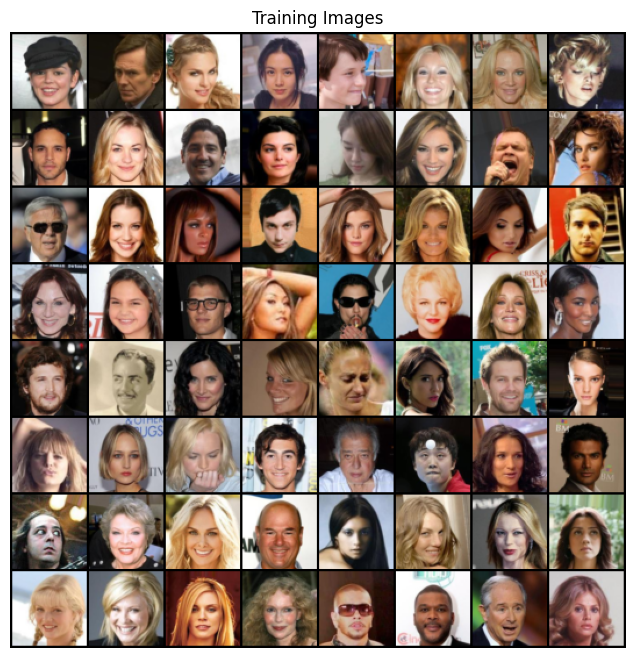

In [24]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).permute(1,2,0))
plt.show()